In [1]:
import sys
import gpytorch
import numpy as np
import pandas as pd
import torch
from datetime import datetime
from scipy.stats import qmc
import itertools
from itertools import combinations_with_replacement, combinations, permutations

import bo_methods_lib
from bo_methods_lib.bo_methods_lib.GPBO_Classes_New import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Class_fxns import * #Fix this later
from bo_methods_lib.bo_methods_lib.analyze_data import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Classes_plotters import * #Fix this later
import pympler
import pickle
import signac

from pympler import asizeof

from matplotlib import pyplot as plt

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

#Ignore inconcistent version warning
import warnings
# from sklearn.exceptions import InconsistentVersionWarning
# warnings.filterwarnings(action='ignore', category=InconsistentVersionWarning)

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# #Make GP and Simulator class
results = open_file_helper("workspace/f45528f717f710993bab841f6cfcdc97/BO_Results.gz")

In [3]:
run = 2
biter = 7
gp_object = copy.copy(results[run-1].list_gp_emulator_class[biter-1])
simulator = copy.copy(results[run-1].simulator_class)
exp_data = copy.copy(results[run-1].exp_data_class)
meth_name = Method_name_enum(results[0].configuration["Method Name Enum Value"])
method = GPBO_Methods(meth_name)
# print(gp_object.noise_std)
# print(simulator.noise_std)
# print(float(scipy.special.polygamma(1, (4*simulator.noise_std**2)/2)))
# print(gp_object.scalerY.lambdas_)

In [5]:
#Scale training data if necessary
feature_train_data_scaled = gp_object.scalerX.transform(gp_object.feature_train_data)
y_train_data_scaled = gp_object.scalerY.transform(gp_object.train_data.y_vals.reshape(-1,1))
y = y_train_data_scaled
# y = gp_object.train_data.y_vals.reshape(-1,1)

Text(0.5, 1.0, 'Histogram of CS17 Train')

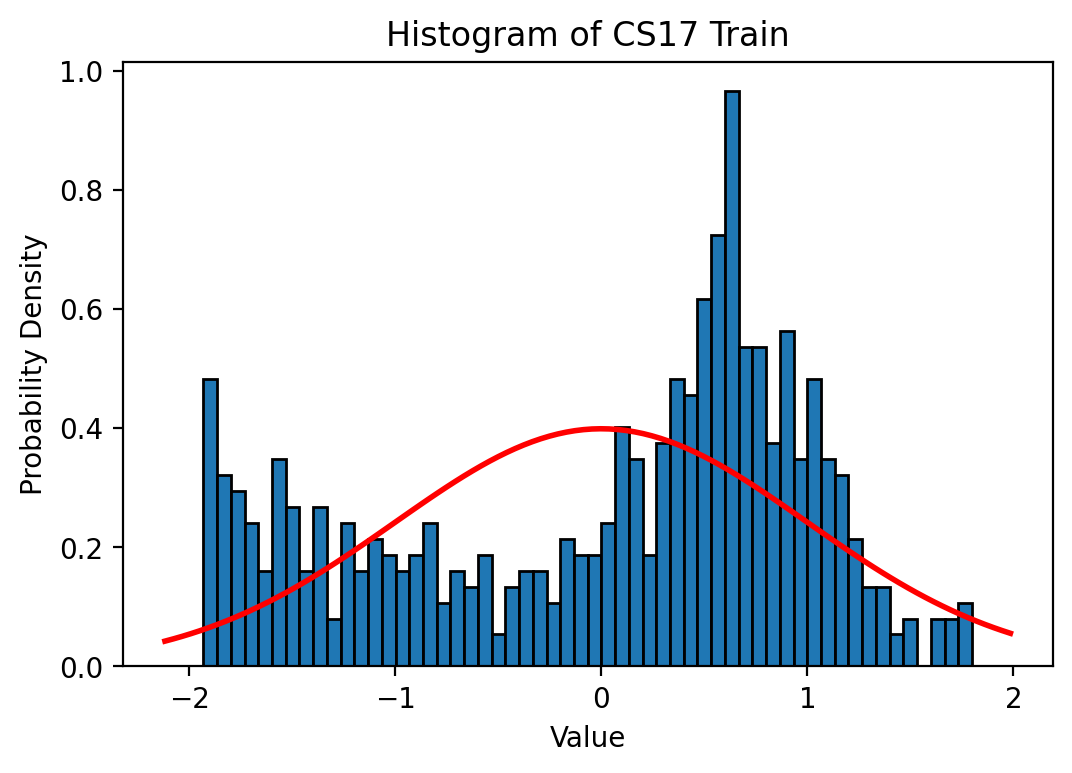

In [6]:
plt.hist(y, bins=int(len(y)/10), density=True, edgecolor='black')  # Adjust the number of bins as needed
xmin, xmax = plt.xlim() 
mu, std = norm.fit(y[~np.isnan(y)])
x = np.linspace(xmin, xmax, 100) 
p = norm.pdf(x, mu, std) 
plt.plot(x, p, 'r', linewidth=2) 


# Add labels and title
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('Histogram of CS17 Train')

In [7]:
#Evaluate gp_mean over x values
#Generate validation data
val_data = simulator.gen_sim_data(15, exp_data.get_num_x_vals(), Gen_meth_enum(1), Gen_meth_enum(2), 1.0, simulator.seed, False)
if method.emulator == False:
    val_data = simulator.sim_data_to_sse_sim_data(method, val_data, exp_data, 1.0, False)
feat_val = gp_object.featurize_data(val_data)

# gp_object.retrain_GP = 25


#Get gp mean
#Change hps of fit gp model or retrain GP
# simulator.noise_std = np.sqrt(float(scipy.special.polygamma(1, (4*simulator.noise_std**2)/2)))
# gp_object.noise_std = None
# new_gp_model = gp_object.set_gp_model()
# gp_object.train_gp(new_gp_model)
# gp_object.fit_gp_model.kernel_.k1.k2.length_scale = np.array([3.46, 3.34, 0.708, 3.74, 0.444, 3.5])
# gp_object.fit_gp_model.kernel_.k2.noise_level = 0.0577
# gp_object.fit_gp_model.kernel_.k1.k1.constant_value = 4

misc_gp_mean, misc_var_return = gp_object.eval_gp_mean_var_misc(val_data, feat_val, covar = False)

In [4]:
print(gp_object.fit_gp_model.kernel_)
#0.976**2 * Matern(length_scale=[3.46, 3.34, 0.708, 3.74, 0.444, 0.464], nu=2.5) + WhiteKernel(noise_level=0.0577)
#0.965**2 * Matern(length_scale=[3.31, 2.83, 0.667, 2.2, 0.365, 0.395], nu=2.5) + WhiteKernel(noise_level=0.00259)

0.973**2 * Matern(length_scale=[3.98, 3, 0.55, 3.75, 0.488, 0.463], nu=2.5) + WhiteKernel(noise_level=0.0781)


MSE: 0.03602505693842526


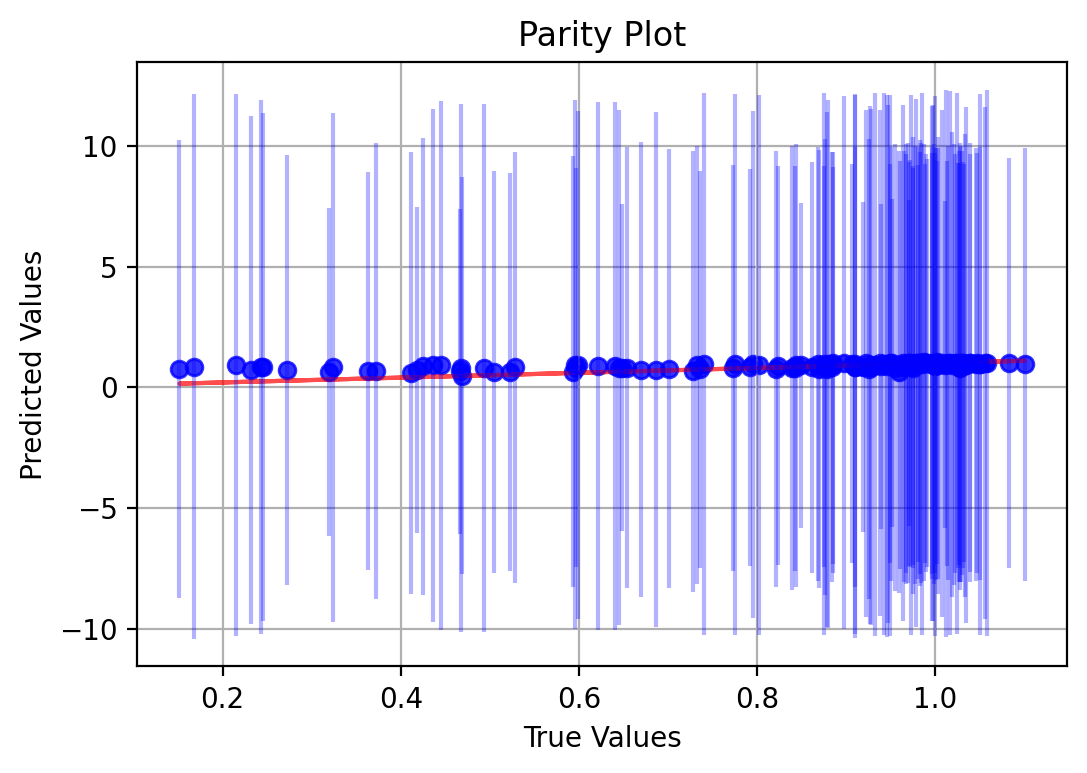

In [8]:
mse= np.sum((val_data.y_vals - misc_gp_mean)**2)/len(val_data.y_vals)
print("MSE:", mse)
plt.figure()
plt.plot(val_data.y_vals, val_data.y_vals, color='red', alpha=0.7)
plt.scatter(val_data.y_vals, misc_gp_mean, color='blue', alpha=0.7)
plt.errorbar(val_data.y_vals, misc_gp_mean, yerr = 1.96*np.sqrt(abs(misc_var_return)), alpha=0.3, fmt = 'o', color = "blue")
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Parity Plot')
plt.grid(True)
plt.show()